# EndoSign: End-to-End Demo Analysis
*Demonstrates all core project functionality with example (dummy) data.*

---

In [4]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from endosign.data_loader import load_patient_data, validate_patient_data
from endosign.reporting import generate_profiling_report, generate_markdown_report, generate_text_report
from endosign.classification import train_and_evaluate_classifier
from endosign.preprocessing import (clean_data, fill_missing_biomarkers, log_transform_biomarkers,
                                    remove_biomarker_outliers, normalize_biomarkers, encode_rasrm_stage)
from endosign.visualization import (plot_group_counts, multiplot_biomarkers, multiplot_endo_class,
                                    plot_biomarker_heatmap, plot_biomarker_correlation,plot_dimensionality_reduction,multiplot_embedding)
from endosign.biomarkers import compare_biomarkers, biomarker_kruskal , biomarker_corr_with_feature, biomarker_stats
from endosign.clustering import reduce_dimensions, cluster_patients




In [5]:
# Load the example data
df = load_patient_data("../data/example/dummy_data.csv")
assert validate_patient_data(df), "Data format error!"

# Show quick preview
print("Shape:", df.shape)
display(df.head())

Shape: (200, 56)


,Patient_ID,Group,Age,BMI,rASRM_stage,Leiomyoma,Infertility,Pain_Score,Hormonal_Medication,Batch,...,Cytokine_27,Cytokine_28,Cytokine_29,Cytokine_30,Cytokine_31,Cytokine_32,Cytokine_33,Cytokine_34,Cytokine_35,Cytokine_36
0,P001,Endometriosis,42,26.1,III,Yes,No,9.8,No,C,...,5.075150,5.481754,5.818130,7.411637,1.564656,6.896286,6.499491,8.053625,6.895024,2.046686
1,P002,Control,38,20.5,NaN,No,No,2.1,No,B,...,4.370618,3.668613,6.333256,3.126410,5.472285,4.388091,0.970198,8.805116,6.349390,7.115602
2,P003,Endometriosis,29,26.4,II,Yes,Yes,4.7,No,A,...,5.258736,5.738033,2.300149,2.255842,6.809924,2.527043,5.668654,10.730424,3.763270,3.935712
3,P004,Endometriosis,35,26.1,IV,Yes,Yes,8.6,No,B,...,0.238522,5.248571,4.089602,7.359884,4.548387,7.548880,4.420037,3.196015,3.410213,4.222864
4,P005,Endometriosis,26,21.6,III,Yes,Yes,9.5,Yes,A,...,1.340636,6.872112,2.305492,6.463796,7.872859,4.809318,3.322999,10.648441,0.855290,2.752243


In [6]:
biomarker_cols = [col for col in df.columns if col.startswith("Cytokine_")]

df = clean_data(df)
print("df shape after cleaning:", df.shape)
df = log_transform_biomarkers(df, biomarker_cols)
df = remove_biomarker_outliers(df, biomarker_cols)
print("df shape after outliers removal:", df.shape)
df = fill_missing_biomarkers(df, biomarker_cols)
print("df shape after filling missing:", df.shape)
df = normalize_biomarkers(df, biomarker_cols)
df = encode_rasrm_stage(df)
print("df shape after preprocessing:", df.shape)

df shape after cleaning: (200, 56)
df shape after outliers removal: (170, 56)
df shape after filling missing: (170, 56)
df shape after preprocessing: (170, 57)


/home/codespace/.local/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


/workspaces/EndoSign/endosign/visualization.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


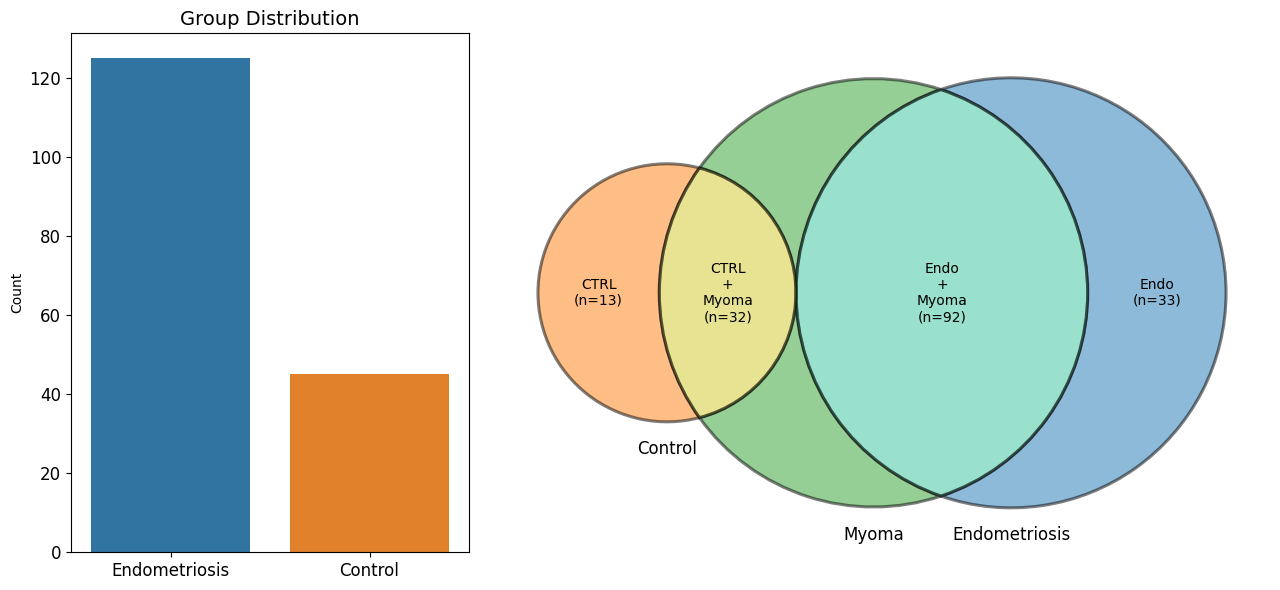

In [7]:
plot_group_counts(df)

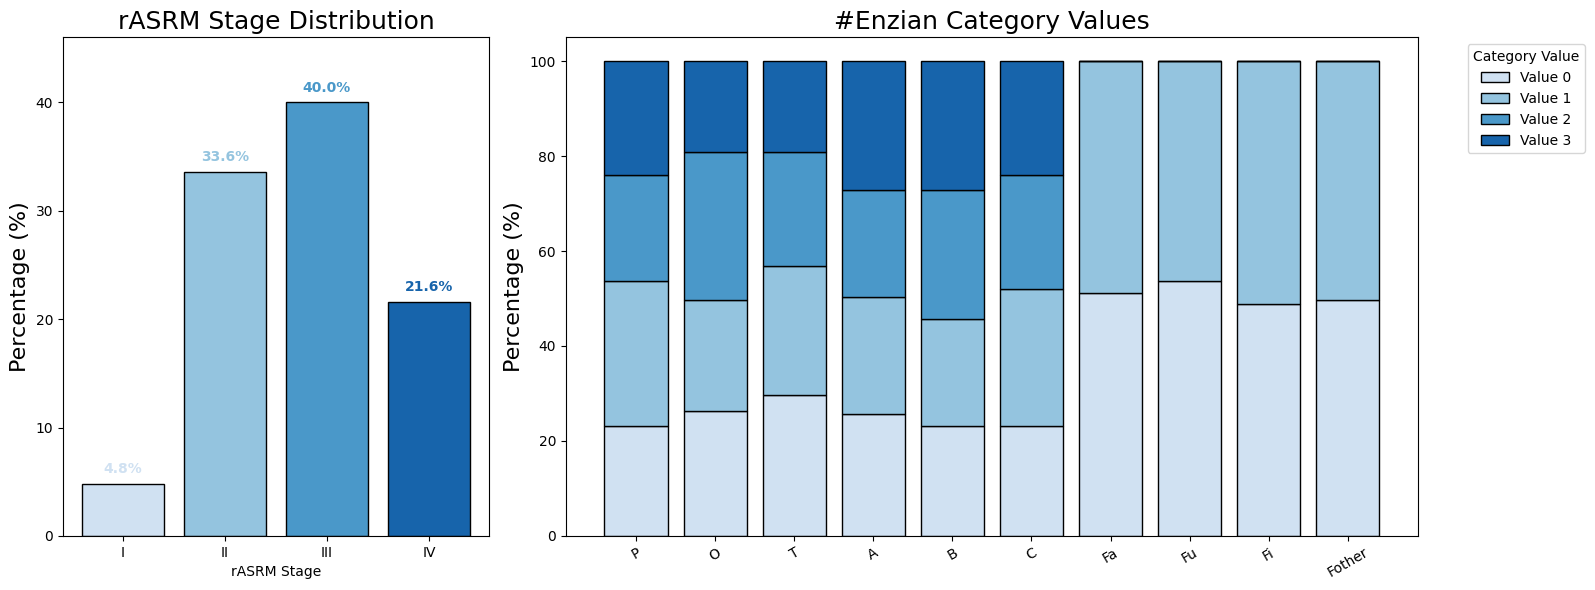

In [8]:
multiplot_endo_class(df)

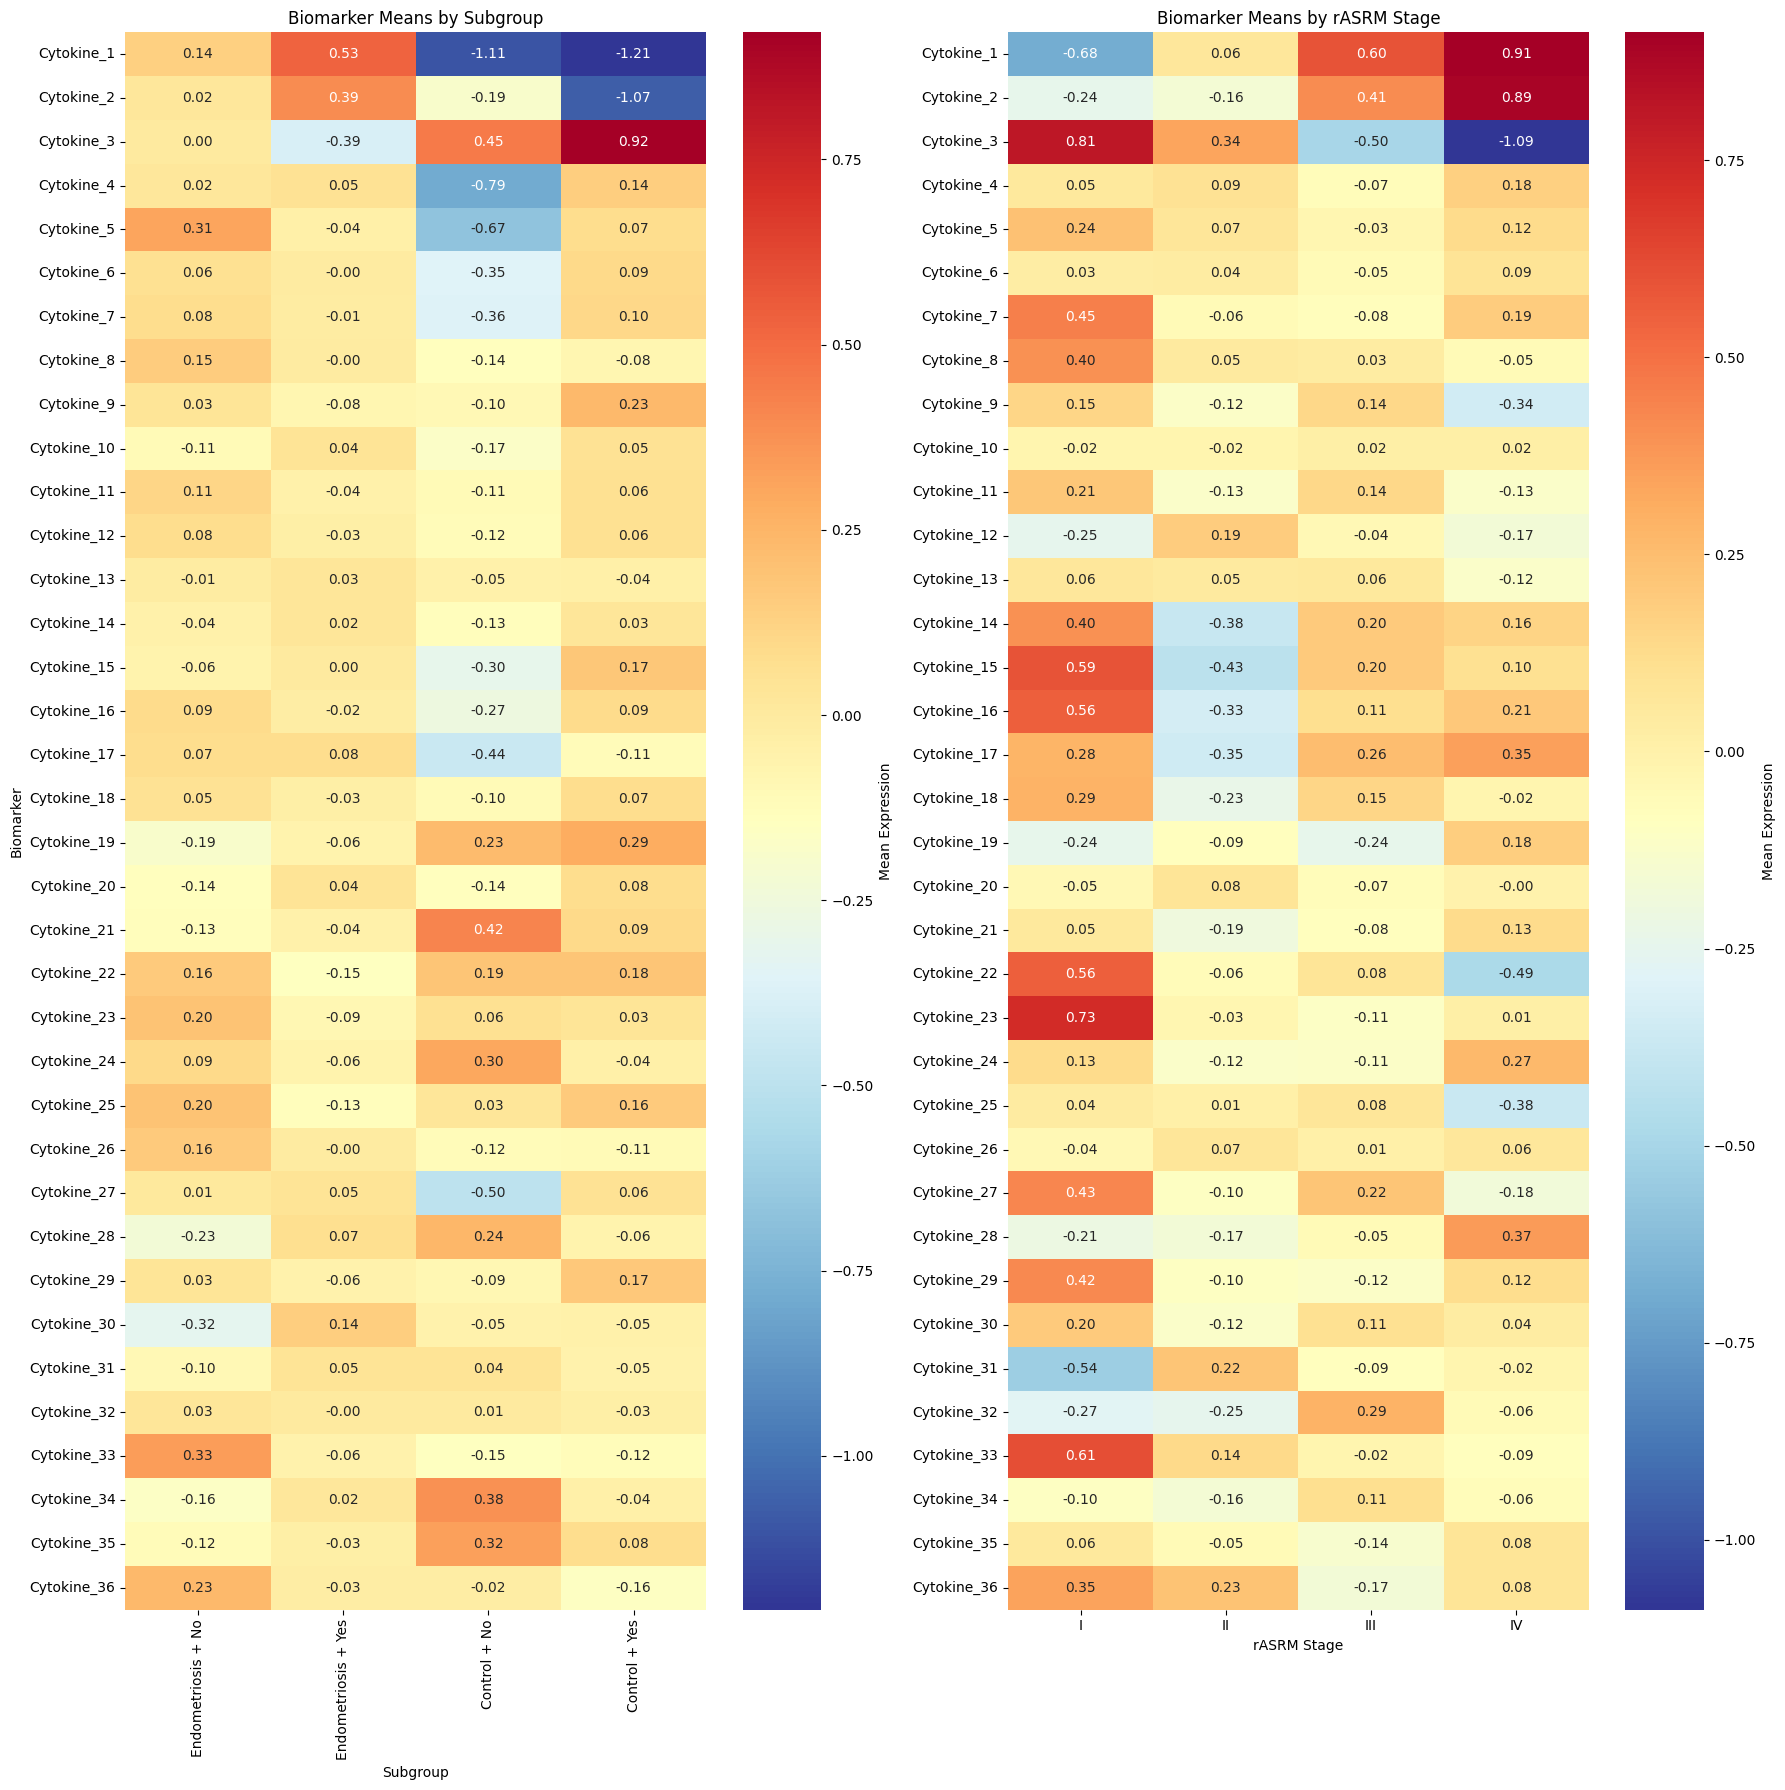

In [9]:
plot_biomarker_heatmap(df, biomarker_cols)

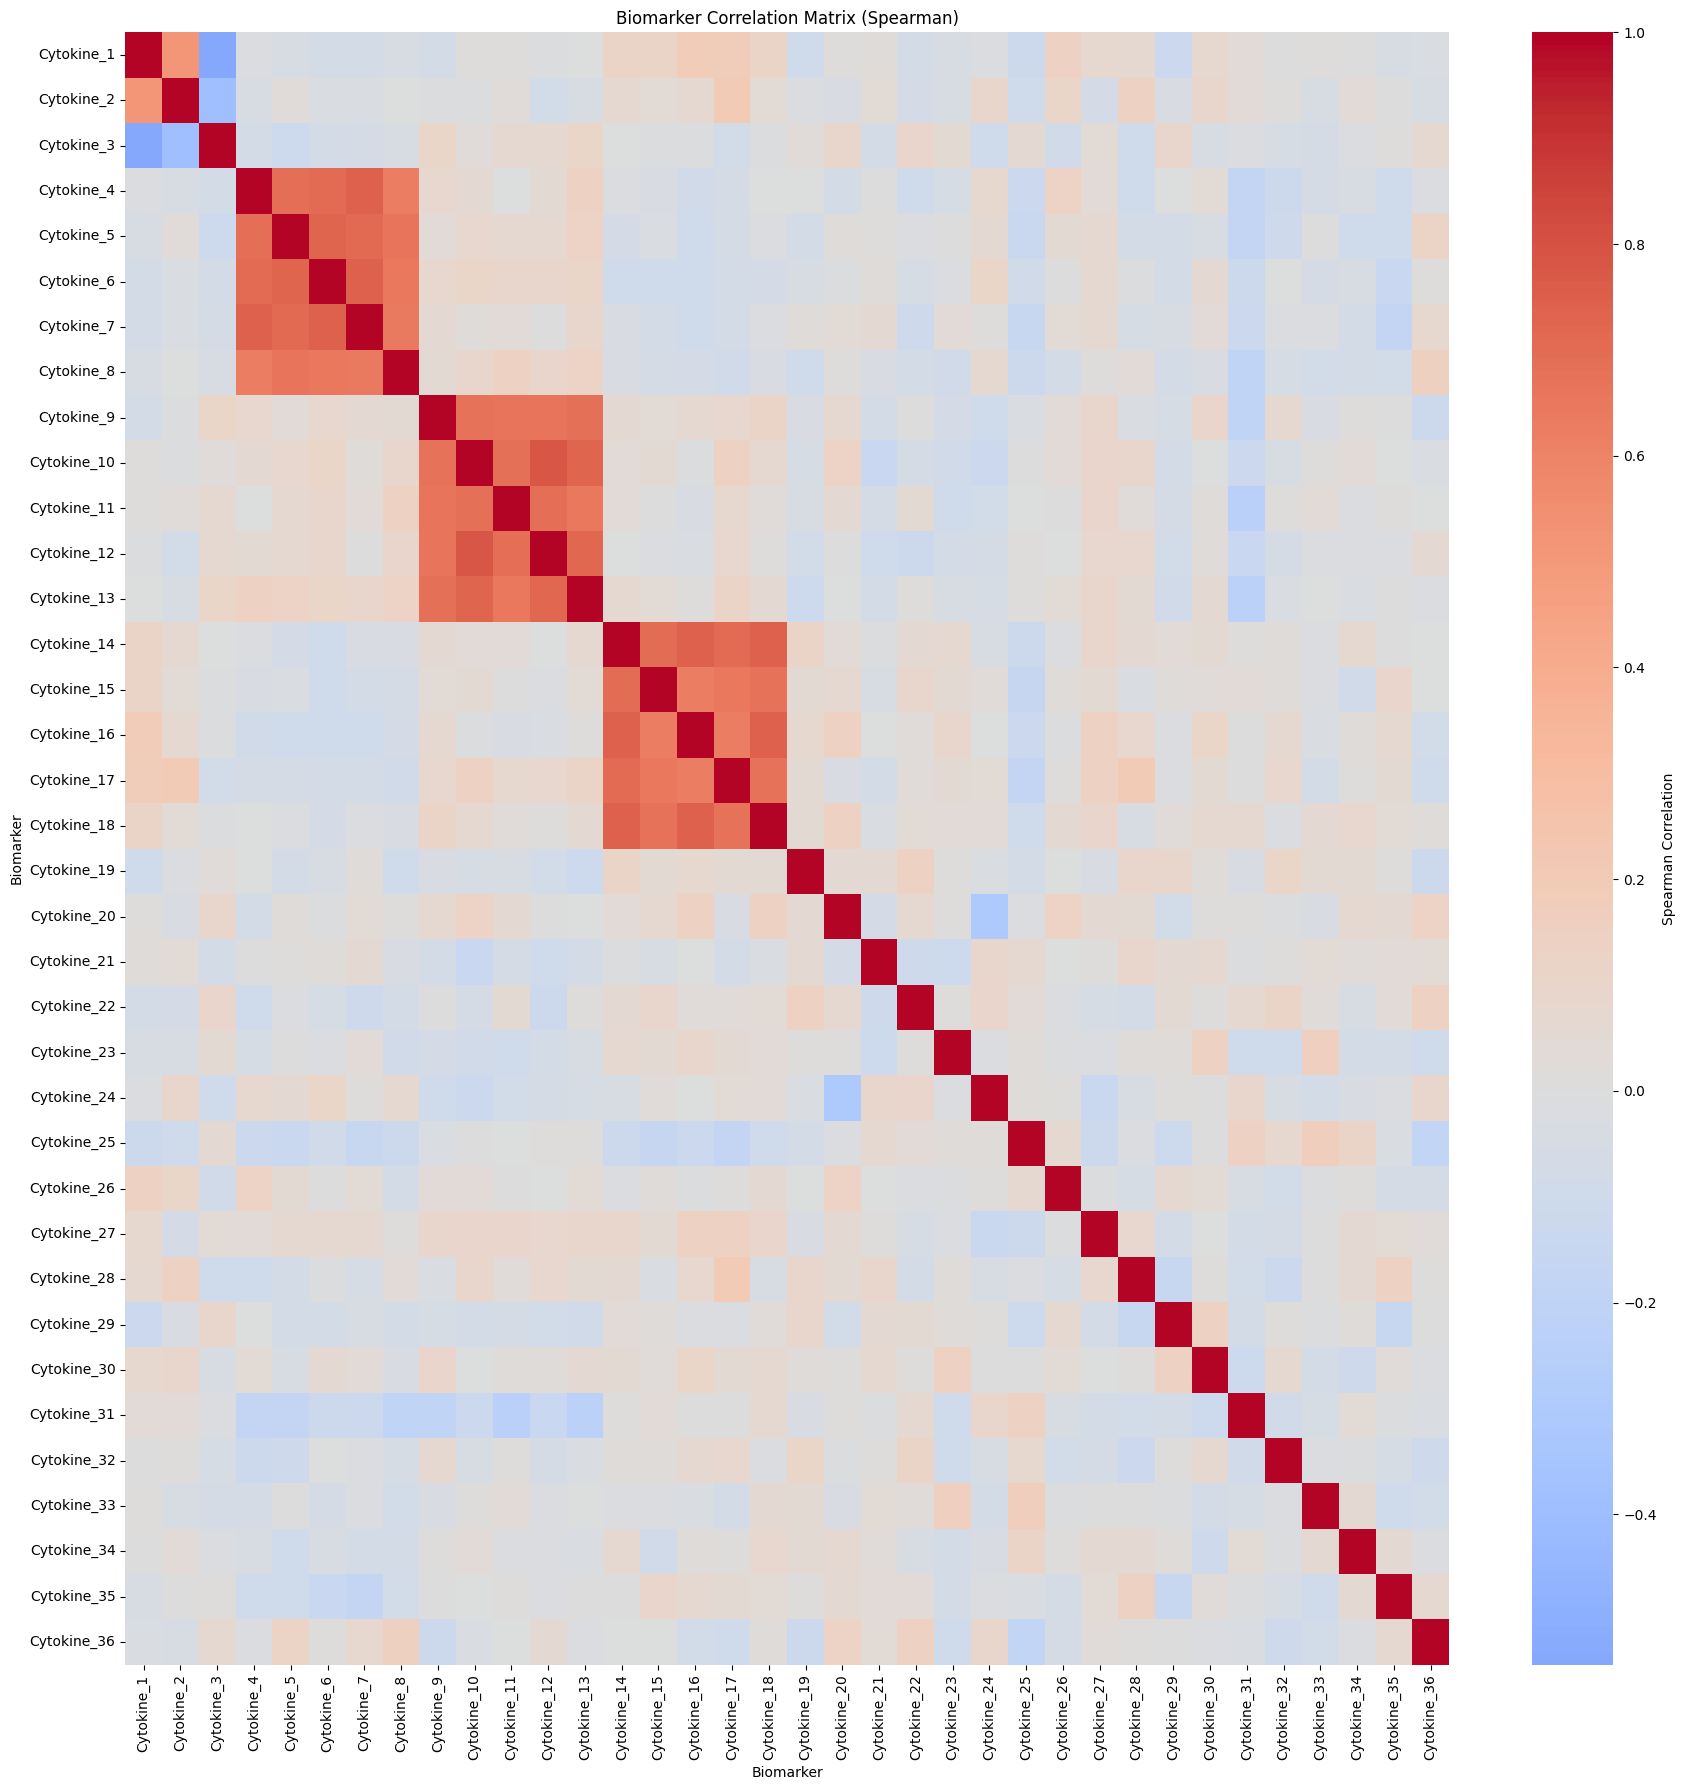

In [10]:
plot_biomarker_correlation(df, biomarker_cols, method="spearman", annot=False)

/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


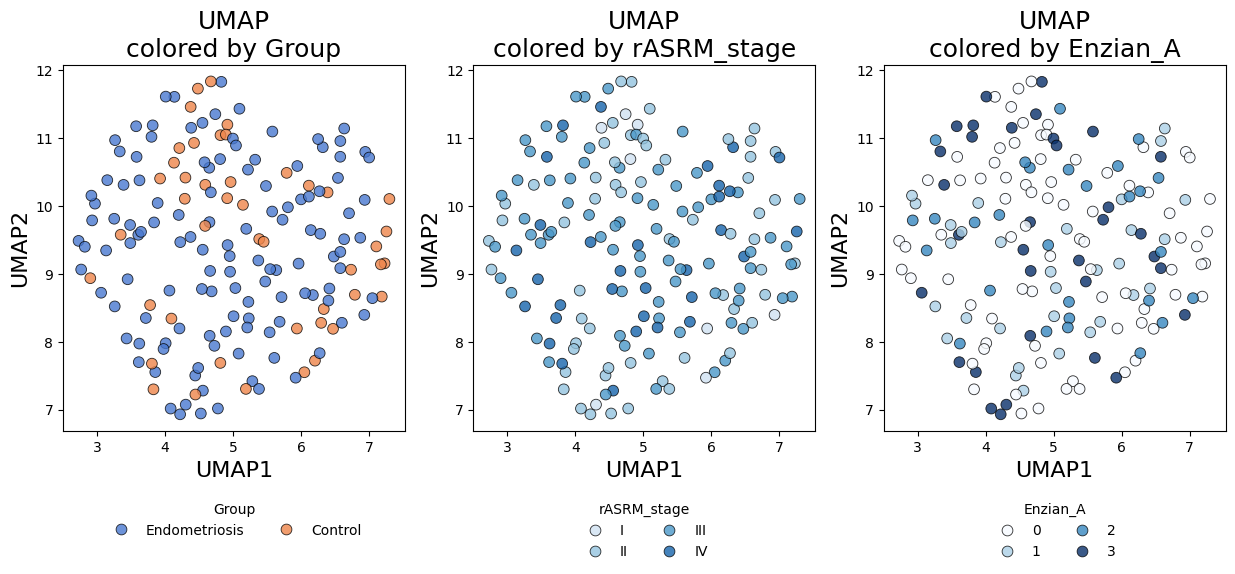

In [11]:
biomarker_cols = [col for col in df.columns if col.startswith("Cytokine_")]
plot_dimensionality_reduction(
    df, biomarker_cols, 
    method='umap', 
    color_by=['Group', 'rASRM_stage', 'Enzian_A']
)

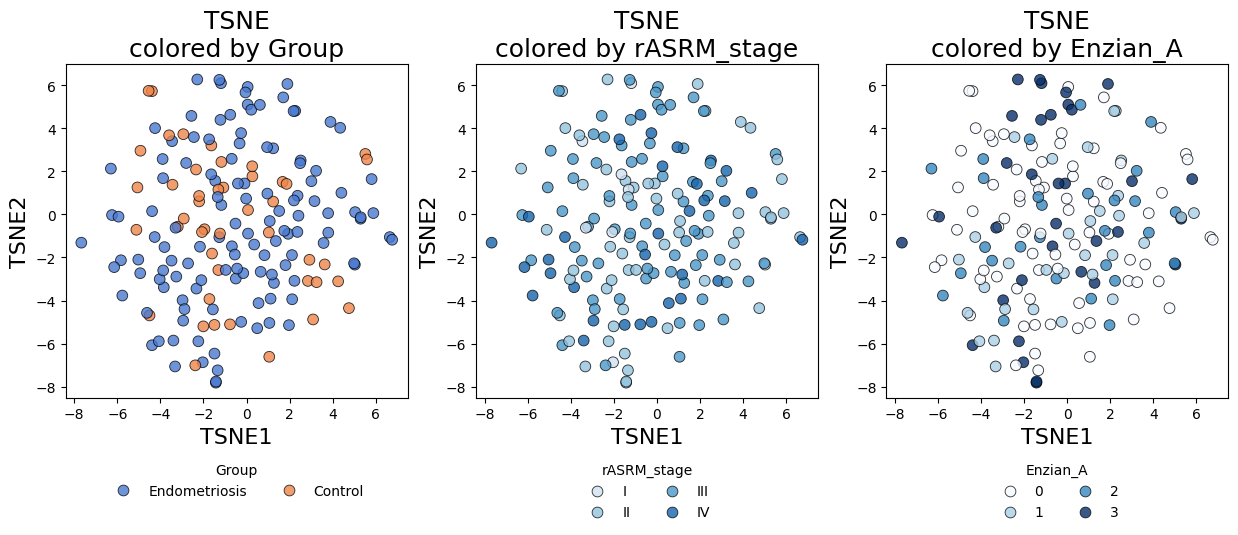

In [12]:
plot_dimensionality_reduction(
    df, biomarker_cols, 
    method='tsne', 
    color_by=['Group', 'rASRM_stage', 'Enzian_A']
)


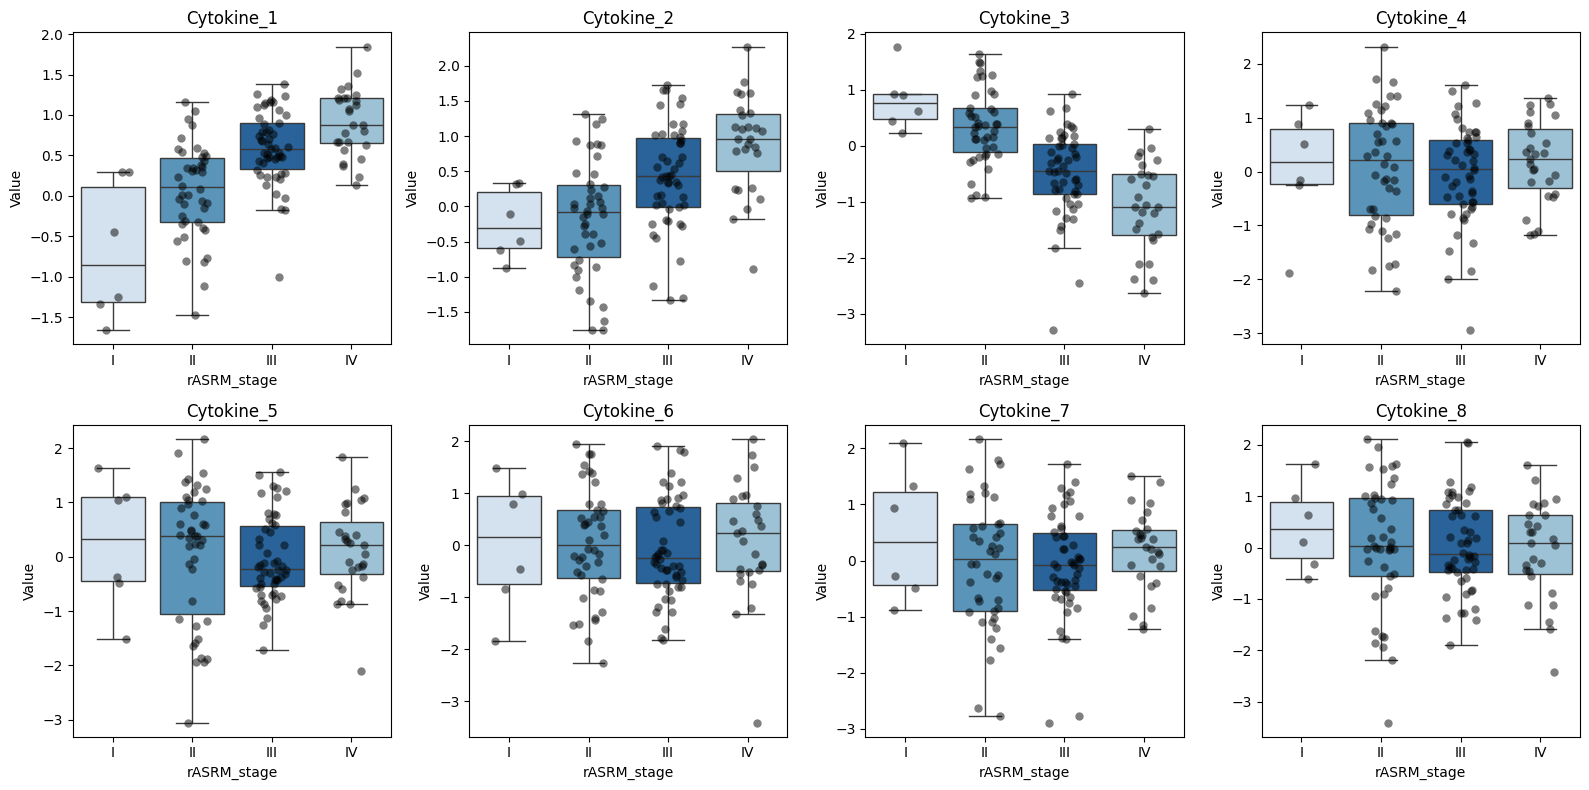

In [13]:
multiplot_biomarkers(
    df, biomarker_cols[:8],
    group_by='rASRM_stage',
    group_order=['I', 'II', 'III', 'IV'],
    palette='Blues_r',
    subset_condition=lambda d: d['Group'] == 'Endometriosis',
    jitter=0.2,
    alpha=0.5,
    marker_size=6
)


/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


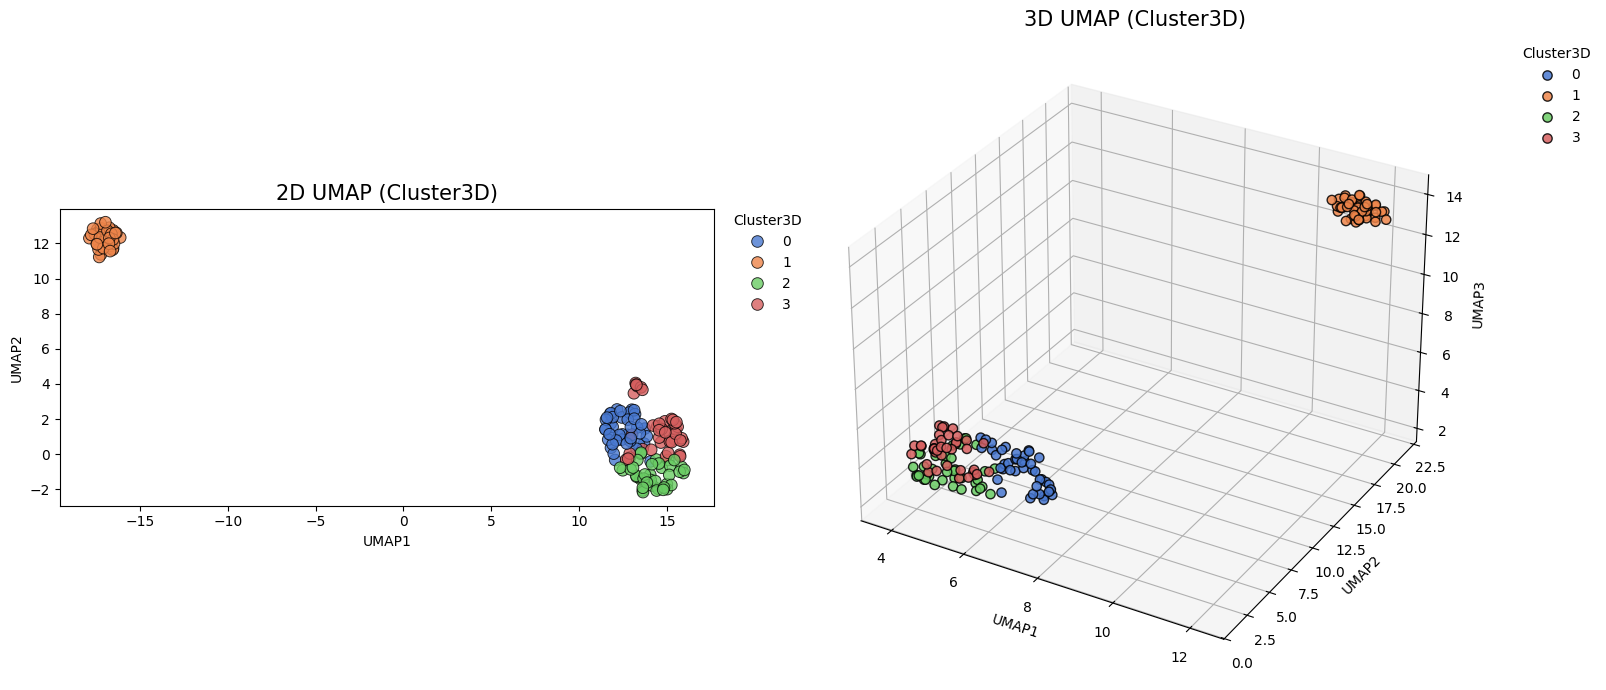

In [14]:
# --- 1. Select Enzian Feature Columns (all patients, no filtering) ---
enzian_cols = [col for col in df.columns if col.startswith("Enzian_")]
X_enz = df[enzian_cols]

# --- 2. Compute 2D and 3D UMAP Embeddings ---
from endosign.clustering import reduce_dimensions

embedding_2d = reduce_dimensions(X_enz, method='umap', n_components=2)
embedding_3d = reduce_dimensions(X_enz, method='umap', n_components=3)

# --- 3. Assign Cluster Labels (on embedding, optional) ---
from endosign.clustering import cluster_patients

df['Cluster2D'] = cluster_patients(embedding_2d, method='kmeans', n_clusters=4)
df['Cluster3D'] = cluster_patients(embedding_3d, method='kmeans', n_clusters=4)

# --- 4. Visualization: 2D and 3D Multiplot ---
from endosign.visualization import multiplot_embedding

multiplot_embedding(
    df, embedding_2d, embedding_3d,
    color_by='Cluster3D',         # or 'Cluster2D', 'Cluster3D', etc.
    cluster_col=None   # for style/shapes; can be None
)

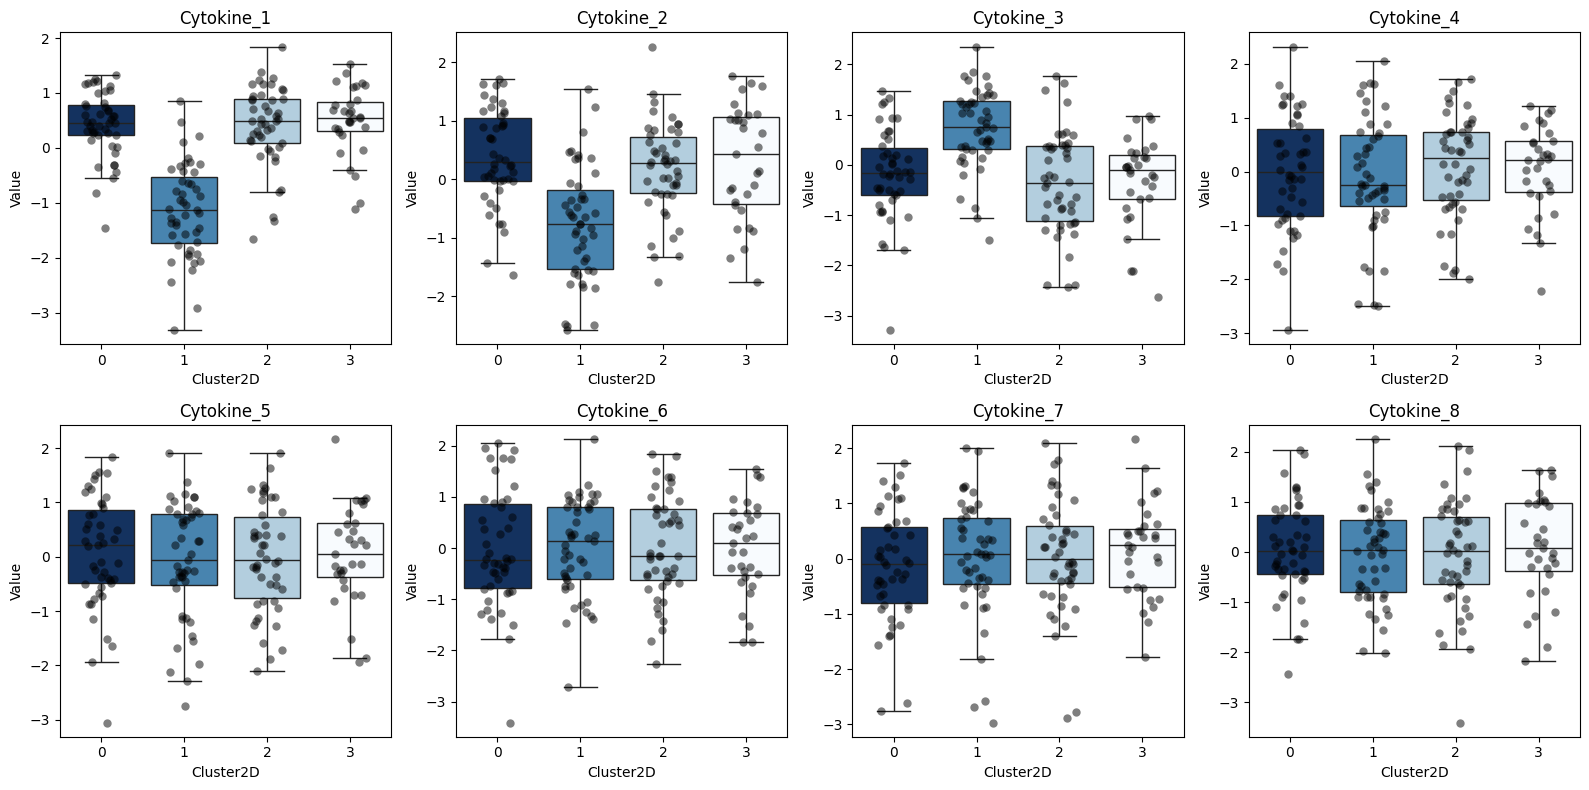

In [15]:
multiplot_biomarkers(
    df, biomarker_cols[:8],
    group_by='Cluster2D',
    group_order=['0', '1', '2', '3'],
    palette='Blues_r',
    jitter=0.2,
    alpha=0.5,
    marker_size=6
)


In [17]:
# Compare all biomarkers between Endometriosis and Controls
stats_table = compare_biomarkers(df, biomarker_cols)
display(stats_table.head(10))

,Biomarker,Endometriosis_median,Control_median,U_stat,p_value,p_adj
0,Cytokine_1,0.481606,-1.184617,5215.0,2.174485e-17,7.828145e-16
2,Cytokine_3,-0.201173,0.841815,996.0,1.415004e-10,2.547008e-09
1,Cytokine_2,0.312779,-0.772621,4545.0,9.501097e-10,1.140132e-08
18,Cytokine_19,0.048112,0.323818,2210.0,3.347696e-02,3.012927e-01
34,Cytokine_35,0.124338,0.506183,2386.0,1.324090e-01,7.789428e-01
16,Cytokine_17,0.126627,-0.097503,3210.0,1.608441e-01,7.789428e-01
26,Cytokine_27,0.267231,-0.074485,3200.0,1.716512e-01,7.789428e-01
21,Cytokine_22,0.024019,0.291506,2452.0,2.035327e-01,7.789428e-01
24,Cytokine_25,-0.017051,0.425473,2452.0,2.035327e-01,7.789428e-01
20,Cytokine_21,0.048892,0.298721,2462.0,2.163730e-01,7.789428e-01


In [18]:
# Kruskal-Wallis for rASRM trends
kruskal_df = biomarker_kruskal(df, biomarker_cols)
display(kruskal_df.head(10))

,Biomarker,H_stat,p_value
2,Cytokine_3,53.436223,1.479927e-11
0,Cytokine_1,45.516623,7.185569e-10
1,Cytokine_2,29.684451,1.607910e-06
14,Cytokine_15,13.026811,4.578981e-03
16,Cytokine_17,12.673633,5.398279e-03
13,Cytokine_14,11.119444,1.109722e-02
15,Cytokine_16,10.238293,1.664546e-02
31,Cytokine_32,8.115034,4.369317e-02
35,Cytokine_36,7.898501,4.815662e-02
21,Cytokine_22,7.039006,7.066485e-02


In [20]:
# Correlation with pain
corr_table = biomarker_corr_with_feature(df, biomarker_cols, feature_col='rASRM_stage')
display(corr_table.head(10))

,Biomarker,rho,p_value,p_adj
2,Cytokine_3,-0.654138,1.320074e-16,4.752265e-15
0,Cytokine_1,0.602315,1.081470e-13,1.946646e-12
1,Cytokine_2,0.488521,7.483463e-09,8.980155e-08
16,Cytokine_17,0.254646,4.159183e-03,3.743265e-02
27,Cytokine_28,0.196173,2.833674e-02,2.040245e-01
14,Cytokine_15,0.178772,4.606957e-02,2.764174e-01
13,Cytokine_14,0.168219,6.076050e-02,3.124826e-01
31,Cytokine_32,0.160534,7.370890e-02,3.316900e-01
35,Cytokine_36,-0.152928,8.863563e-02,3.393924e-01
15,Cytokine_16,0.150320,9.427566e-02,3.393924e-01
